- 데이터 개수가 워낙 많다보니 이미지 자체로 하기보다는 transform을 통한 정규화 선택


transforms.ToTensor(): 이미지 데이터를 PyTorch 텐서로 변환합니다. 이 변환은 데이터 타입을 float로 변경하고, 픽셀 값의 범위를 [0, 255]에서 [0.0, 1.0]으로 조정

transforms.Normalize((0.5,), (0.5,)): 정규화 과정을 통해 픽셀 값의 범위를 [-1, 1]로 조정 -> 이는 모델 학습을 더 안정적이고 효율적

In [ ]:
# 필요한 라이브러리 가져오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [ ]:
# CNN 아키텍처 정의

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
## MNIST 데이터세트를 로드하고 훈련, 검증, 테스트 세트로 분할

# Transformations applied on each image
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading MNIST dataset
dataset = datasets.MNIST(root='data/', download=True, transform=transform)

# Splitting dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12764766.12it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 344314.50it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3168826.70it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2560899.15it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



best_model (only save the model for the best validation loss) : /content/best_model.pth

In [ ]:


# 정확도 계산 함수
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# CNN 모델
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, save_path='best_model.pth'):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_acc = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_acc += acc

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = total_acc / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                acc = accuracy(outputs, labels)
                total_val_loss += loss.item()
                total_val_acc += acc

        epoch_val_loss = total_val_loss / len(val_loader)
        epoch_val_acc = total_val_acc / len(val_loader)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {epoch_val_acc:.4f}')

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Saved Better Model with Val Loss: {best_val_loss:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Define transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST dataset
dataset = datasets.MNIST(root='data/', download=True, transform=transform)

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model, Loss, and Optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 모델 훈련하고 모든 결과를 받는 부분
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader)


Epoch 1/10, Train Loss: 0.2021, Val Loss: 0.0633, Train Acc: 0.9380, Val Acc: 0.9798
Saved Better Model with Val Loss: 0.0633
Epoch 2/10, Train Loss: 0.0520, Val Loss: 0.0572, Train Acc: 0.9837, Val Acc: 0.9835
Saved Better Model with Val Loss: 0.0572
Epoch 3/10, Train Loss: 0.0360, Val Loss: 0.0418, Train Acc: 0.9885, Val Acc: 0.9880
Saved Better Model with Val Loss: 0.0418
Epoch 4/10, Train Loss: 0.0261, Val Loss: 0.0449, Train Acc: 0.9916, Val Acc: 0.9863
Epoch 5/10, Train Loss: 0.0207, Val Loss: 0.0443, Train Acc: 0.9931, Val Acc: 0.9868
Epoch 6/10, Train Loss: 0.0150, Val Loss: 0.0439, Train Acc: 0.9948, Val Acc: 0.9888
Epoch 7/10, Train Loss: 0.0146, Val Loss: 0.0415, Train Acc: 0.9950, Val Acc: 0.9885
Saved Better Model with Val Loss: 0.0415
Epoch 8/10, Train Loss: 0.0108, Val Loss: 0.0409, Train Acc: 0.9964, Val Acc: 0.9894
Saved Better Model with Val Loss: 0.0409
Epoch 9/10, Train Loss: 0.0082, Val Loss: 0.0523, Train Acc: 0.9972, Val Acc: 0.9879
Epoch 10/10, Train Loss: 0.008

(1) Plot the training and validation loss as a function of the number of epochs for this problem, i.e., x axis: epochs, y axis: training or validation loss.



(2) Report training, validation, and out of sample testing accuracy.

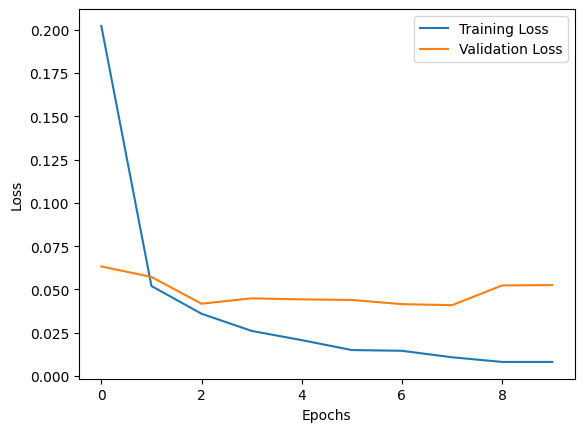

In [ ]:
# 학습 및 검증 손실 플롯

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


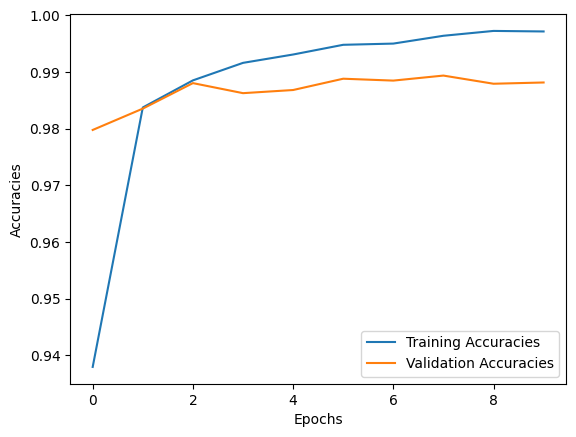

In [ ]:
# 학습 및 검증 정확성 플롯

plt.plot(train_accuracies, label='Training Accuracies')
plt.plot(val_accuracies, label='Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()
plt.show()


In [ ]:
# 테스트 데이터에서 모델 평가

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

accuracy = evaluate_model(model, test_loader)
print(f'Accuracy on test data: {accuracy:.2f}%')


Accuracy on test data: 98.77%
